<font color='blue'> **Jocope ______________________________________________________________________________** </font> 

In [1]:
import os ; import pandas as pd ; import flopy ; import numpy as np ; import matplotlib.pyplot as plt; from pathlib import Path ; import pickle ; import flopy.utils.binaryfile as bf  
from ipywidgets import interact ; import shutil ; import matplotlib.colors ; import gstools as gs; import matplotlib.pyplot as pt   ; import numpy as np ; from gstools.random import MasterRNG

TA=Path("TA"); TA.mkdir(exist_ok=True)  ;AUX = Path("./_aux") ; ID='Flujo' ;EX='E:\\15_REPOS\\00_BETAMI\\bin\\mf2005.exe'  ;EX2='E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64.exe' 

In [2]:
nlay = 30 ; nrow = 1 ; ncol = 100   ;delr=10.;  delc=1.   ; top=510.    ;BOTM = np.ones((nlay), dtype=np.int32)    ; nper = 3 ; NSTP = [1]+[1]*2     ; steady = [True] +[False]*2 
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)    ; ibound[1:,:,0] = -1 ; ibound[21:,:,-1] = -1        ; print('ibound:',ibound.shape)   ; perlen = [1]    +[864000]*1 +[2523743999]*1  
for i in range (nlay):         BOTM[i]= 500 -(i*10)
with open(AUX/ "d_chdspd", 'rb') as handle:
    chdspd = pickle.load(handle)  ; pd.DataFrame(chdspd[0]).to_csv (TA/ 'd2_chdspd.csv')  # .iloc[:29]
OC_S = {} 
for kper in range(nper):                
    for kstp in range(NSTP[kper]):          OC_S[(kper, kstp)] = ['save head','save budget']
x = y = range(100)   ; KA  = gs.Gaussian(dim=2, var=1, len_scale=10)  ; srf = gs.SRF(KA, seed=20170519)    ; field = srf.structured([x, y])   #; srf.plot(  )

ibound: (30, 1, 100)


In [8]:
MF  = flopy.modflow.Modflow       (ID, exe_name=EX, model_ws=TA)
dis = flopy.modflow.ModflowDis    (MF, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc              , top=top, botm=BOTM, nper=nper, perlen=perlen, steady=steady, itmuni=1, lenuni=2)
bas    = flopy.modflow.ModflowBas (MF, ibound=ibound, strt=top)                                           ; chd = flopy.modflow.ModflowChd (MF, stress_period_data=chdspd)
lpf    = flopy.modflow.ModflowLpf (MF, laytyp=1, ipakcb=53, hk=1.0, vka=1.0 , hdry=-2e+20, chani=-1.0, ss=1e-05, sy=0.15)                                     # hk, vka=hk
pcg    = flopy.modflow.ModflowPcg (MF, mxiter=85, iter1=57, npcond=1, nbpol=1, hclose=1e-05, rclose=1e-05, relax=1,iprpcg=0, mutpcg=0, ihcofadd=0)
oc     = flopy.modflow.ModflowOc  (MF,stress_period_data=OC_S, compact=True)                         #;lmt    = flopy.modflow.ModflowLmt (MF, output_file_name='mt3d.ftl')
MF.write_input() ; MF.run_model(silent=True)

(True, [])

<font color='orange'> **RES ____________________________________________________________________________________________________________** </font> 

In [4]:
hdobj   = flopy.utils.HeadFile(os.path.join(TA, ID+'.hds'))         ; HH = hdobj.get_data() ; HH.shape                     ;CBC = bf.CellBudgetFile(TA/'Flujo.cbc')   
nlay,nrow,ncol = 30,1,100   ; HH = bf.HeadFile(TA/'Flujo.hds')      ; TI = HH.get_times()   ; print('times TI', TI, '____ perlen', perlen)

for iplot, time in enumerate(TI):
    head = HH.get_data(totim=time)
    QX   = CBC.get_data(text='FLOW RIGHT FACE', totim=time)[0] ;QZ=CBC.get_data(text='FLOW LOWER FACE', totim=time)[0]     ;QY=np.zeros((nlay,nrow,ncol),dtype=float)

HA = HH.get_data(totim=time)                                 ; HB =HA.reshape  (HA.shape [0], -1) ;pd.DataFrame(HB).to_csv(TA/"HH_2D.csv")  #; print(HH.shape)
QX = CBC.get_data(text='FLOW RIGHT FACE', totim=time)[0]     ; QQX =QX.reshape (QX.shape [0], -1) ;pd.DataFrame(QQX).to_csv(TA/"QX_2D.csv")  #; print(QQX.shape)
QZ = CBC.get_data(text='FLOW RIGHT FACE', totim=time)[0]     ; QQZ =QZ.reshape (QZ.shape [0], -1) ;pd.DataFrame(QQZ).to_csv(TA/"QZ_2D.csv")  ; print(QQZ.shape)

times TI [1.0, 864001.0, 2524608000.0] ____ perlen [1, 864000, 2523743999]
(30, 100)


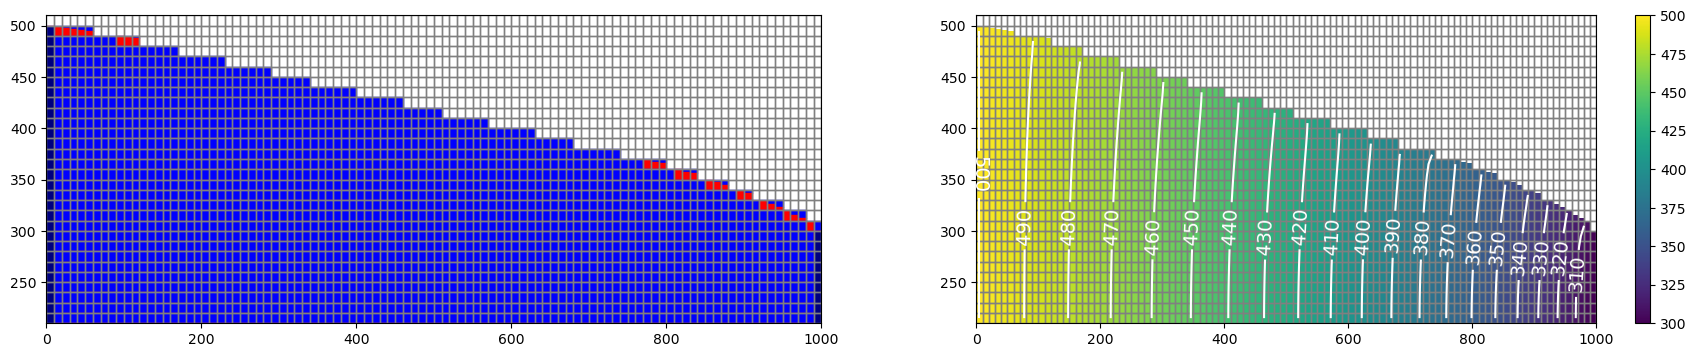

In [10]:
MG=MF.lpf.vka.array                                          ; HA = HH.get_data(totim=TI[1])  #___ 0|1|2
fig = plt.figure(figsize=(22, 4))
ax = fig.add_subplot(121)
XS = flopy.plot.PlotCrossSection(model=MF, line={'Row':0})   ; fb = XS.plot_fill_between(head, colors=['b','r'])    ; PAT = XS.plot_bc('CHD', head=head)  ; LIN = XS.plot_grid()     
#SX=flopy.plot.PlotCrossSection(model=MF, line={'Row': 0})     ; VK  = SX.plot_array(MG)                              ; SX.plot_grid(colors='white', lw=0.5) ; plt.colorbar(VK) ;plt.title("K")
ax = fig.add_subplot(122)                                     ; LEV = np.arange(300, 501, 10)
XS = flopy.plot.PlotCrossSection(model=MF, line={'Row':0})    ; CC = XS.contour_array(head, masked_values=[999.,-2.00000E+20], levels=LEV, colors='w')  ;plt.clabel(CC,colors='w',fontsize=14)
HV = XS.plot_array(HA, head=HA, masked_values=[999.00, -2.00000E+20])    
#PAT = XS.plot_ibound(head=head) ; 
LIN = XS.plot_grid()       ;fig.colorbar(HV,orientation='vertical'); pt.show()

In [6]:
#chdspd={}
#chdspd[0]=[[i, 0, 0, 500., 500.] for i in range(1,30)]  /   for i in range (21,30):     chdspd[0]   .append(([i, 0, 99, 300.,300.])) 
#chdspd[1]=[[i, 0, 0, 500., 500.] for i in range(1,30)]  /   for i in range (21,30):     chdspd[1]   .append(([i, 0, 99, 300.,300.])) 
#chdspd[2]=[[i, 0, 0, 500., 500.] for i in range(1,30)]  /   for i in range (21,30):     chdspd[2]   .append(([i, 0, 99, 300.,300.])) 
[[i, 0, 0, 500., 500.] for i in range(1,5)]

[[1, 0, 0, 500.0, 500.0],
 [2, 0, 0, 500.0, 500.0],
 [3, 0, 0, 500.0, 500.0],
 [4, 0, 0, 500.0, 500.0]]

In [11]:
hdobj   = flopy.utils.HeadFile(os.path.join(TA, ID+'.hds'))         ; HH = hdobj.get_data() ; HH.shape                     ;CBC = bf.CellBudgetFile(TA/'Flujo.cbc')   
nlay,nrow,ncol = 30,1,100   ; HH = bf.HeadFile(TA/'Flujo.hds')      ; TI = HH.get_times()   ; print('times TI', TI, '____ perlen', perlen)

HA = HH.get_data(totim=TI[1])  #___ 0|1|2

times TI [1.0, 864001.0, 2524608000.0] ____ perlen [1, 864000, 2523743999]


In [12]:
with open(TA/'a6_temp.csv', "w") as file:
    for item in TI:
        file.write("%s\n" % item)